In [1]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten, Dropout,LSTM, GRU, Bidirectional,Input,Concatenate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
np.random.seed(42)

In [5]:
df=pd.read_csv("text_preprocessed.csv")

In [6]:
df.head()

,Unnamed: 0.1,Unnamed: 0,LABEL,Category_Label,CLEANED_PRODUCT_TITLE,CLEANED_TITLE,CLEANED_TEXT,RATING,VERIFIED_PURCHASE,REVIEW_LENGTH,NUM_PUNCTUATIONS,CAPS_COUNT,stopwords_count,characters_count,matchesPTITLE
0,0,0,1,20,targus pauk u ultra mini usb keypad black,useful,least think save day keep around case need som...,4,0,116,3,2,10,91,7
1,1,1,1,29,note battery stalion strength replacement mah ...,new era battery,lithium battery something new introduce market...,4,1,404,7,4,28,329,24
2,2,2,1,2,fisher price papasan cradle swing starlight,swing well,purchase swing baby month pretty much grown lo...,3,0,248,8,6,25,188,5
3,3,3,1,18,casio m b standard function desktop calculator,great compute,look inexpensive desk calcolatur work everythi...,4,0,212,4,6,18,165,6
4,4,4,1,3,shine whiten zero peroxide teeth whiten system...,twice week,twice week result great use teeth whiten solut...,4,0,331,6,4,34,260,11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20924 entries, 0 to 20923
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0.1           20924 non-null  int64 
 1   Unnamed: 0             20924 non-null  int64 
 2   LABEL                  20924 non-null  int64 
 3   Category_Label         20924 non-null  int64 
 4   CLEANED_PRODUCT_TITLE  20924 non-null  object
 5   CLEANED_TITLE          20924 non-null  object
 6   CLEANED_TEXT           20924 non-null  object
 7   RATING                 20924 non-null  int64 
 8   VERIFIED_PURCHASE      20924 non-null  int64 
 9   REVIEW_LENGTH          20924 non-null  int64 
 10  NUM_PUNCTUATIONS       20924 non-null  int64 
 11  CAPS_COUNT             20924 non-null  int64 
 12  stopwords_count        20924 non-null  int64 
 13  characters_count       20924 non-null  int64 
 14  matchesPTITLE          20924 non-null  int64 
dtypes: int64(12), objec

In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
unique_words = set()
for column in ['CLEANED_PRODUCT_TITLE', 'CLEANED_TITLE', 'CLEANED_TEXT']:
    unique_words.update(df[column].str.split().explode())

voc_size = len(unique_words)
print(f"Number of unique words: {voc_size}")
df['combined_reviews'] = df['CLEANED_PRODUCT_TITLE'] + ' ' + df['CLEANED_TITLE'] + ' ' + df['CLEANED_TEXT']
df['review_length'] = df['combined_reviews'].str.split().str.len()
maxlen = int(df['review_length'].quantile(0.95))
print(f"Max sequence length (95th percentile): {maxlen}")


Number of unique words: 36534
Max sequence length (95th percentile): 107


In [9]:
voc_size=36534
max_length=107
epoch=30
batch_size=64

In [10]:
df['combined_reviews'] = df['CLEANED_PRODUCT_TITLE'] + ' ' + df['CLEANED_TITLE'] + ' ' + df['CLEANED_TEXT']

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(df['combined_reviews'])
sequences = tokenizer.texts_to_sequences(df['combined_reviews'])
word_index = tokenizer.word_index

In [12]:
embedded_docs=pad_sequences(sequences,padding='post',maxlen=max_length)
print(embedded_docs)

[[ 7517 20520    92 ...     0     0     0]
 [  431    54  3055 ...     0     0     0]
 [ 2163    16 20521 ...     0     0     0]
 ...
 [15063   105   132 ...     0     0     0]
 [20493   130 36494 ...     0     0     0]
 [12074 20502   598 ...     0     0     0]]


In [13]:
from sklearn.preprocessing import  StandardScaler
numeric_features = df[['RATING', 'VERIFIED_PURCHASE', 'REVIEW_LENGTH', 'NUM_PUNCTUATIONS',
                       'CAPS_COUNT', 'stopwords_count', 'characters_count', 'matchesPTITLE']].values
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_features)
numeric_data_shape = numeric_data.shape[1]
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    embedded_docs, numeric_data, df['LABEL'], test_size=0.2, random_state=42)

In [14]:
def simplernn(voc_size, max_length, numeric_input_shape):
    text_input = Input(shape=(max_length,), name='text_input')
    embedding_layer = Embedding(input_dim=voc_size, output_dim=128, input_length=max_length)(text_input)
    simplernn_layer = SimpleRNN(units=128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

    numeric_input = Input(shape=(numeric_input_shape,), name='numeric_input')
    numeric_dense = Dense(units=64, activation='relu')(numeric_input)

    concatenated = Concatenate()([simplernn_layer, numeric_dense])
    dense_layer = Dense(units=64, activation='relu')(concatenated)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def lstm(voc_size, max_length, numeric_input_shape):

    text_input = Input(shape=(max_length,), name='text_input')
    embedding_layer = Embedding(input_dim=voc_size, output_dim=128, input_length=max_length)(text_input)
    lstm_layer = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

    numeric_input = Input(shape=(numeric_input_shape,), name='numeric_input')
    numeric_dense = Dense(units=64, activation='relu')(numeric_input)

    concatenated = Concatenate()([lstm_layer, numeric_dense])
    dense_layer = Dense(units=64, activation='relu')(concatenated)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def gru(voc_size, max_length, numeric_input_shape):

    text_input = Input(shape=(max_length,), name='text_input')
    embedding_layer = Embedding(input_dim=voc_size, output_dim=128, input_length=max_length)(text_input)
    gru_layer = GRU(units=128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

    numeric_input = Input(shape=(numeric_input_shape,), name='numeric_input')
    numeric_dense = Dense(units=64, activation='relu')(numeric_input)

    concatenated = Concatenate()([gru_layer, numeric_dense])
    dense_layer = Dense(units=64, activation='relu')(concatenated)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


def bi_gru(voc_size, max_length, numeric_input_shape):

    text_input = Input(shape=(max_length,), name='text_input')
    embedding_layer = Embedding(input_dim=voc_size, output_dim=128, input_length=max_length)(text_input)
    gru_layer = Bidirectional(GRU(units=128, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)

    numeric_input = Input(shape=(numeric_input_shape,), name='numeric_input')
    numeric_dense = Dense(units=64, activation='relu')(numeric_input)

    concatenated = Concatenate()([gru_layer, numeric_dense])
    dense_layer = Dense(units=64, activation='relu')(concatenated)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def bi_lstm(voc_size, max_length, numeric_input_shape):

    text_input = Input(shape=(max_length,), name='text_input')
    embedding_layer = Embedding(input_dim=voc_size, output_dim=128, input_length=max_length)(text_input)
    lstm_layer = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)

    numeric_input = Input(shape=(numeric_input_shape,), name='numeric_input')
    numeric_dense = Dense(units=64, activation='relu')(numeric_input)

    concatenated = Concatenate()([lstm_layer, numeric_dense])
    dense_layer = Dense(units=64, activation='relu')(concatenated)
    output_layer = Dense(units=1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[text_input, numeric_input], outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [15]:

def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Validation Loss: {loss:.4f}')
    print(f'Validation Accuracy: {accuracy:.4f}')

    predictions = model.predict(X_test)
    predicted_classes = np.round(predictions).astype(int).flatten()
    true_classes = np.round(np.array(y_test)).astype(int).flatten()

    # Get the classification report
    report = classification_report(true_classes, predicted_classes, target_names=['Class 0', 'Class 1'], output_dict=True)
    print(report)

    # Overall metrics
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    print(f'Overall Precision: {precision:.4f}')
    print(f'Overall Recall: {recall:.4f}')
    print(f'Overall F1 Score: {f1_score:.4f}')

    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Simple RNN

Epoch 1/30
210/210 [==============================] - 49s 225ms/step - loss: 0.4797 - accuracy: 0.7976 - val_loss: 0.4488 - val_accuracy: 0.8133
Epoch 2/30
210/210 [==============================] - 37s 178ms/step - loss: 0.4454 - accuracy: 0.8155 - val_loss: 0.4417 - val_accuracy: 0.8163
Epoch 3/30
210/210 [==============================] - 38s 180ms/step - loss: 0.4409 - accuracy: 0.8179 - val_loss: 0.4389 - val_accuracy: 0.8157
Epoch 4/30
210/210 [==============================] - 33s 155ms/step - loss: 0.4384 - accuracy: 0.8209 - val_loss: 0.4430 - val_accuracy: 0.8157
Epoch 5/30
210/210 [==============================] - 34s 161ms/step - loss: 0.4374 - accuracy: 0.8179 - val_loss: 0.4406 - val_accuracy: 0.8148
Epoch 6/30
131/131 [==============================] - 1s 10ms/step - loss: 0.4383 - accuracy: 0.8122
Validation Loss: 0.4383
Validation Accuracy: 0.8122
131/131 [==============================] - 1s 9ms/step
{'Class 0': {'precision': 0.7759139784946236, 'recall': 0.871918801

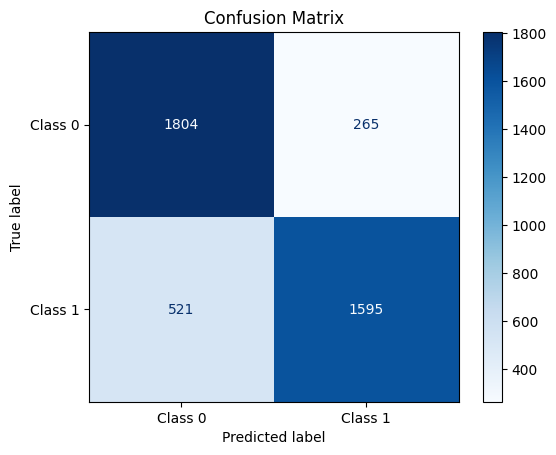

In [18]:

rnn_model = simplernn(voc_size=voc_size, max_length=max_length, numeric_input_shape=numeric_data_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = rnn_model.fit([X_train_text, X_train_numeric], y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2,callbacks=[early_stopping])
evaluate_model(rnn_model, [X_test_text, X_test_numeric], y_test)



LSTM

Epoch 1/30
210/210 [==============================] - 131s 601ms/step - loss: 0.4630 - accuracy: 0.8096 - val_loss: 0.4404 - val_accuracy: 0.8154
Epoch 2/30
210/210 [==============================] - 122s 582ms/step - loss: 0.4372 - accuracy: 0.8178 - val_loss: 0.4323 - val_accuracy: 0.8172
Epoch 3/30
210/210 [==============================] - 128s 612ms/step - loss: 0.4270 - accuracy: 0.8248 - val_loss: 0.4431 - val_accuracy: 0.8121
Epoch 4/30
210/210 [==============================] - 130s 620ms/step - loss: 0.4129 - accuracy: 0.8306 - val_loss: 0.4379 - val_accuracy: 0.8166
Epoch 5/30
131/131 [==============================] - 6s 44ms/step - loss: 0.4323 - accuracy: 0.8165
Validation Loss: 0.4323
Validation Accuracy: 0.8165
131/131 [==============================] - 7s 46ms/step
{'Class 0': {'precision': 0.8064060292039567, 'recall': 0.8274528757854036, 'f1-score': 0.8167938931297709, 'support': 2069}, 'Class 1': {'precision': 0.8268671193016489, 'recall': 0.805765595463138, 'f1-sco

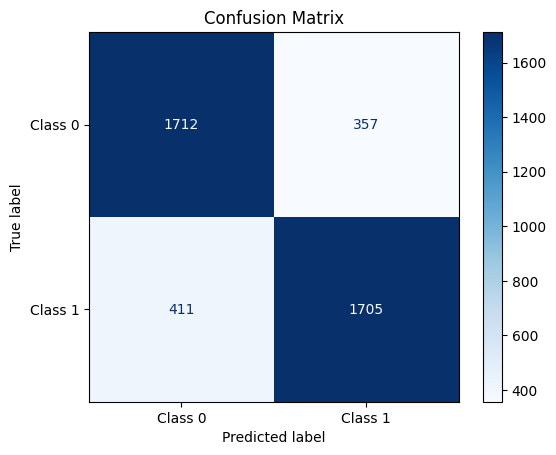

In [16]:

lstm_model = lstm(voc_size=voc_size, max_length=max_length, numeric_input_shape=numeric_data_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = lstm_model.fit([X_train_text, X_train_numeric], y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2,callbacks=[early_stopping])
evaluate_model(lstm_model, [X_test_text, X_test_numeric], y_test)


GRU

Epoch 1/30
210/210 [==============================] - 110s 501ms/step - loss: 0.4594 - accuracy: 0.8116 - val_loss: 0.4386 - val_accuracy: 0.8151
Epoch 2/30
210/210 [==============================] - 104s 495ms/step - loss: 0.4312 - accuracy: 0.8220 - val_loss: 0.4336 - val_accuracy: 0.8181
Epoch 3/30
210/210 [==============================] - 106s 507ms/step - loss: 0.4165 - accuracy: 0.8279 - val_loss: 0.4365 - val_accuracy: 0.8163
Epoch 4/30
210/210 [==============================] - 110s 524ms/step - loss: 0.4073 - accuracy: 0.8330 - val_loss: 0.4470 - val_accuracy: 0.8148
Epoch 5/30
131/131 [==============================] - 5s 35ms/step - loss: 0.4338 - accuracy: 0.8184
Validation Loss: 0.4338
Validation Accuracy: 0.8184
131/131 [==============================] - 7s 51ms/step
{'Class 0': {'precision': 0.7912772585669782, 'recall': 0.8593523441275979, 'f1-score': 0.8239110287303059, 'support': 2069}, 'Class 1': {'precision': 0.8498452012383901, 'recall': 0.7783553875236295, 'f1-sc

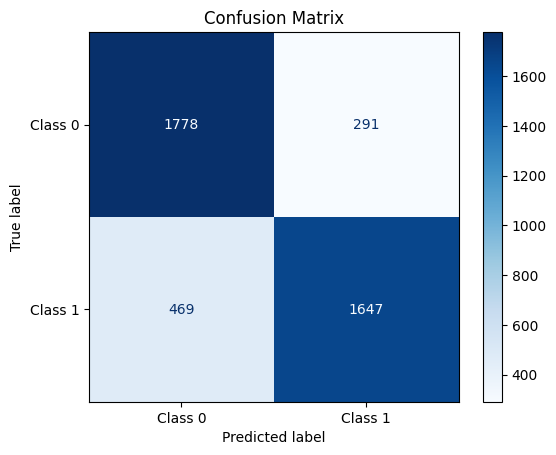

In [17]:

gru_model = gru(voc_size=voc_size, max_length=max_length, numeric_input_shape=numeric_data_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = gru_model.fit([X_train_text, X_train_numeric], y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2,callbacks=[early_stopping])
evaluate_model(gru_model, [X_test_text, X_test_numeric], y_test)


Bidirectional LSTM

Epoch 1/30
210/210 [==============================] - 228s 1s/step - loss: 0.4406 - accuracy: 0.8244 - val_loss: 0.3843 - val_accuracy: 0.8533
Epoch 2/30
210/210 [==============================] - 227s 1s/step - loss: 0.2695 - accuracy: 0.8955 - val_loss: 0.3990 - val_accuracy: 0.8447
Epoch 3/30
210/210 [==============================] - 228s 1s/step - loss: 0.1279 - accuracy: 0.9539 - val_loss: 0.4763 - val_accuracy: 0.8303
Epoch 4/30
131/131 [==============================] - 14s 103ms/step - loss: 0.3749 - accuracy: 0.8545
Validation Loss: 0.3749
Validation Accuracy: 0.8545
131/131 [==============================] - 16s 121ms/step
{'Class 0': {'precision': 0.8653653653653653, 'recall': 0.8356694055099082, 'f1-score': 0.8502581755593804, 'support': 2069}, 'Class 1': {'precision': 0.84453589391861, 'recall': 0.8728733459357277, 'f1-score': 0.8584708343016499, 'support': 2116}, 'accuracy': 0.8544802867383513, 'macro avg': {'precision': 0.8549506296419876, 'recall': 0.854271375722818, '

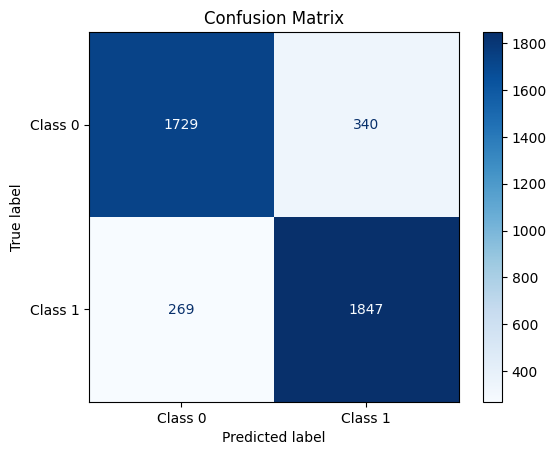

In [18]:

bi_lstm_model = bi_lstm(voc_size=voc_size, max_length=max_length, numeric_input_shape=numeric_data_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = bi_lstm_model.fit([X_train_text, X_train_numeric], y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2,callbacks=[early_stopping])
evaluate_model(bi_lstm_model, [X_test_text, X_test_numeric], y_test)
